## imports

In [16]:
import sys
import os
import h5py

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


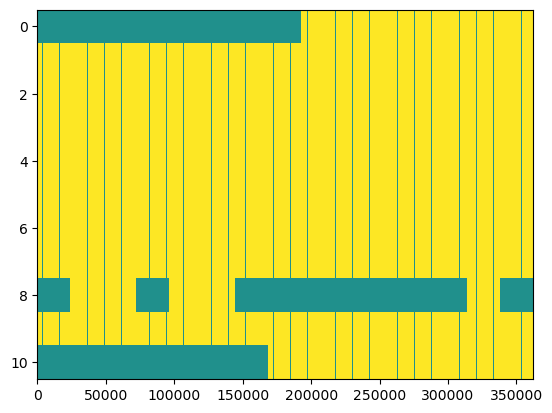

In [2]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

## cascade model

In [10]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

In [11]:
## If there is enough memory on the device, can put the whole dataloader on the GPU
#del train_ds , val_ds
torch.cuda.empty_cache()

data.set_cells()
train_ds = GenericDataset(data[data.train_inds], device=device)
val_ds = GenericDataset(data[data.val_inds], device=device)

  Reset cells_out to full dataset (11 cells).


In [12]:
num_subs = [8, 8, 4]
fws = [21, 9, 9]
XTregB = 0.0001
Greg = 0.001
Creg= None
clayers = []
for ii in range(0,len(num_subs)):
    clayers.append(
        ConvLayer.layer_dict(
            num_filters=num_subs[ii], bias=False, norm_type=1, num_inh=num_subs[ii]//2,
            filter_dims=fws[ii], padding='same', NLtype='relu', initialize_center = True) )
    clayers[ii]['output_norm'] = 'batch'
    clayers[ii]['window'] = 'hamming'
clayers[0]['input_dims'] = data.stim_dims
clayers[0]['reg_vals'] = {'d2xt': XTregB, 'center': Creg, 'bcs':{'d2xt':1} }

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold',
    xstim_n = 'stim', layer_list = clayers )

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True,
    pos_constraint=True,
    initialize_center = True)
readout_par['reg_vals'] = {'glocalx': Greg  }

readout_net = FFnetwork.ffnet_dict(
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_par], ffnet_type='normal')

cnn0 = NDN.NDN( ffnet_list=[scaffold_net, readout_net] )
cnn0.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([72, 8])
  Layer 2:
      weight: torch.Size([72, 4])
Network 1:
  Layer 0:
      weight: torch.Size([720, 11])
      bias: torch.Size([11])


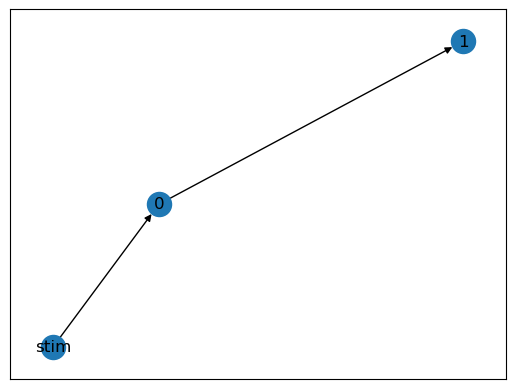

In [13]:
reload(m)
m.draw_model(cnn0)

In [14]:
cnn0.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
LLs1 = cnn0.eval_models(val_ds, null_adjusted=True)
print(LLs1, np.mean(LLs1))


GPU Available: True, GPU Used: True


Validating ver=2: 100%|██████████████████████████████████████████████████| 35/35 [00:00<00:00, 44.01it/s, val_loss=0.412]


Early stopping
Done fitting
  Fit complete: 80.31300902366638 sec elapsed


Eval models: 100%|███████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 94.80it/s]

[ 0.6030021   0.64705974  1.1051824   0.2888955   0.4448229  -0.02977848
  0.0865618   0.12981057 -0.01627207  0.58167005  0.05734444] 0.35439083


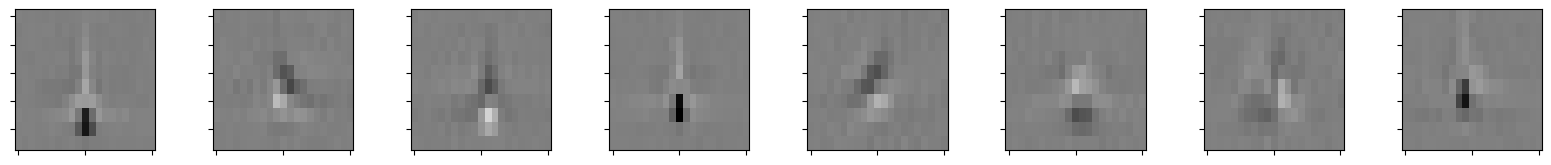

In [15]:
cnn0.plot_filters()

<Figure size 640x480 with 0 Axes>

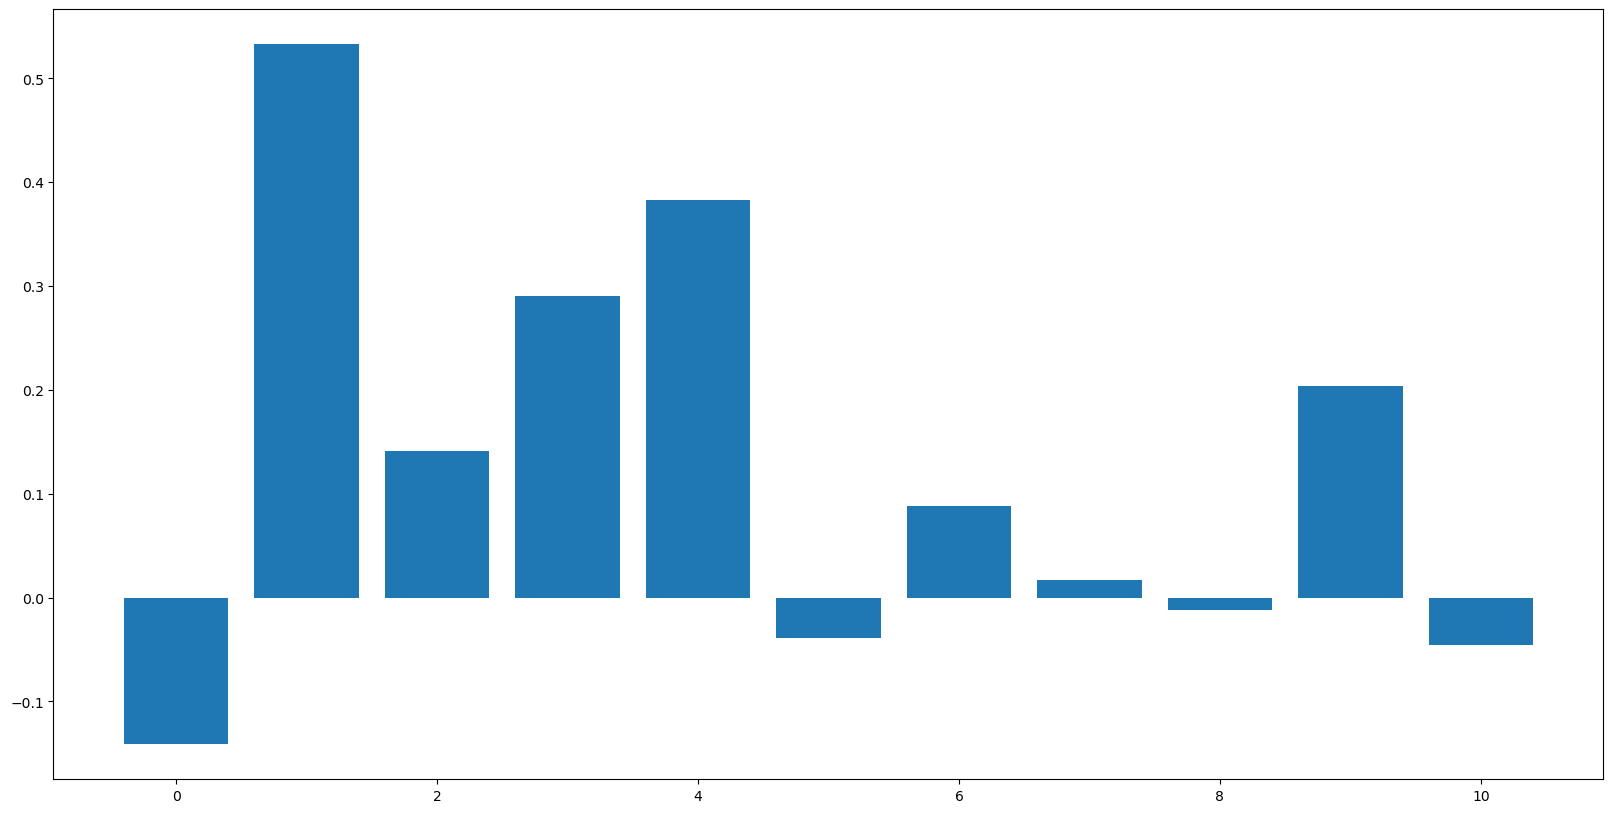

In [18]:
# R2
m.fig()
plt.bar(range(11), met.r2(data, cnn0))
plt.show()

Can't seem to get rid of weird edge artifacts. Very likely the number of parameters is not adequately supported by the data.

## can we fit multiple datasets simultaneously using the DataFilters? Does the NDNT support this, or do I need to add this feature?